# Categorização de avaliações

**Passos:**

1. **Pré-processamento**: Colocar em minúsculo, remover pontuação, stop words (conjunções, preposições, etc) e aplicar stemming ou lematização
    - Stemming: reduz palavras ao seu radical, ignorando as regras linguísticas (é útil para reduzir a dimensionalidade)
    - Lematização: Reduz palavras à sua forma básica, considerando o contexto gramatical (é mais precisa)
2. **Extração de Características**: Usar TF-IDF ou Word2Vec para criar representações vetoriais das avaliações
    - O TF-IDF (term frequence - inverse document frequency) calcula a relevância de cada termo dentro de um documento
    - O Word2Vec captura relações semânticas entre as palavras, criando representações vetoriais densas, que são úteis para capturar o contexto semântico (no entanto, demanda mais recursos computacionais)
3. **Clusterização**: Aplicar K-means em cada método de extração de características para definir categorias as categorias das avaliações
    - Utilização do Elbow Method e do Silhouette Score para definir a quantidade ideal de clusters para cada método
    - Após definir os clusters, as categorias podem ser interpretadas extraindo as palavras mais representativas de cada cluster
4. **Avaliação e Ajuste**: Fazer gráficos para ver a separação dos clusters
5. **Classificação**: Usar o modelo para categorizar novas avaliações de acordo com as categorias definidas

## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# from nltk.stem import SnowballStemmer

import gensim
from gensim.models import Word2Vec

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [2]:
# baixar stopwords e pacotes do nltk
# punkt sequence tokenizer = divide um texto em uma lista de sentenças usando um algoritmo não supervisionado para construir um modelo para abreviação de palavras

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Leticia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Leticia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Leticia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Leticia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\Leticia\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [3]:
# criar stopwords
stop_words = set(stopwords.words('portuguese'))
len(stop_words)

207

In [4]:
# função para stemming
stemmer = nltk.stem.RSLPStemmer()

def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and word.isalpha()]
    return " ".join(tokens)

## 2 Ler base de dados e fazer pre-tratamento

In [74]:
# ler base
df = pd.read_csv('dados/bares_maps/bd-reviews_Reworked.csv')

# remover dicionários vazios
df = df[df['reviews'].notna()]

# extrair nome e comentário do json da coluna de texto
df['name'] = df['reviews'].apply(lambda x: eval(x)['name'])
df['comentario'] = df['reviews'].apply(lambda x: eval(x)['text'])
df['nota'] = df['reviews'].apply(lambda x: eval(x)['stars'])

# selecionar colunas importantes
df = df[['title', 'price', 'categoryName', 'totalScore', 'reviewsCount', 'name', 'comentario', 'nota']]

# remover os comentários que estão vazios
df = df[df['comentario'].notna()]

# fazer pre-tratamento (remover caracteres especiais e colocar em minúsculo)
df['comentario_tratado'] = df['comentario'].apply(lambda x: re.sub('[^A-Za-z0-9áéíóúàèìòùãõñçâêô ]+', '', x.lower()))

# criar coluna de tamanho do texto
df['tamanho_comentario'] = df['comentario_tratado'].apply(lambda x: len(x))

# aplicar o stemming
df['preprocessed_text'] = df['comentario_tratado'].apply(preprocess_text)
print(f"Quantidade de linhas do dataframe: {df.shape[0]}")
df.head()

Quantidade de linhas do dataframe: 6865


,title,price,categoryName,totalScore,reviewsCount,name,comentario,nota,comentario_tratado,tamanho_comentario,preprocessed_text
0,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Flavia Bruno,"Comida boa, apesar de ser a peso. A mesa de sa...",3,comida boa apesar de ser a peso a mesa de sala...,257,com boa apes pes mes sal falt rep com sabor em...
1,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Cristiane B Monteiro,Gosto demais da variedade da comida. Não tem c...,5,gosto demais da variedade da comida não tem ch...,163,gost demal variedad com churrasc outr carn boa...
2,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Joao Laurindo Duarte,"O restaurante vende refeição por quilo, cheque...",4,o restaurante vende refeição por quilo chequei...,171,restaurant vend refe quil cheq hor fim dev fec...
3,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Mayannah Hingstone,Ótima opção para almoço no setor Jaó. Grande v...,5,ótima opção para almoço no setor jaó grande va...,194,ótim opç almoç set jaó grand variedad com opç ...
4,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Deyvid Linhares,Atendimento excelente!\nComida e preço muito b...,5,atendimento excelentecomida e preço muito bom ...,100,atend excelentecom preç bom fic pes gram torn ...


### 2.1 Quantidade de palavras diferentes

In [6]:
# Converte todos os comentários em uma única string
todos_comentarios = " ".join(df['preprocessed_text'])

# Tokeniza os comentários para obter uma lista de palavras
palavras = word_tokenize(todos_comentarios)

# Remove palavras duplicadas transformando em um set, e conta o total de palavras distintas
palavras_distintas = set(palavras)
quantidade_palavras_distintas = len(palavras_distintas)

print(f"Quantidade de palavras distintas: {quantidade_palavras_distintas}")

Quantidade de palavras distintas: 6310


## 3 Vetorização

### 3.1 TF-IDF

In [78]:
vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2, max_features = 5000)
X_tfidf = vectorizer.fit_transform(df['preprocessed_text'])

# ver a matriz criada
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns = vectorizer.get_feature_names_out())
X_tfidf_df.head()

,abacax,abaf,abaix,abandon,abenço,abert,abient,abord,abr,abraç,...,étic,ênfas,íam,ímp,índic,óle,ótim,ótimo,últ,únic
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.116007,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


### 3.2 Word2Vec

In [79]:
tokenized_reviews = df['preprocessed_text'].apply(lambda x: x.split())
word2vec_model = Word2Vec(sentences = tokenized_reviews, vector_size = 100, window = 5, min_count = 2, sg = 1)

def get_average_word2vec(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis = 0) if vectors else np.zeros(100)

df['word2vec_vector'] = df['preprocessed_text'].apply(lambda x: get_average_word2vec(x.split(), word2vec_model))
X_word2vec = np.vstack(df['word2vec_vector'].values)
df.head()

,title,price,categoryName,totalScore,reviewsCount,name,comentario,nota,comentario_tratado,tamanho_comentario,preprocessed_text,word2vec_vector
0,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Flavia Bruno,"Comida boa, apesar de ser a peso. A mesa de sa...",3,comida boa apesar de ser a peso a mesa de sala...,257,com boa apes pes mes sal falt rep com sabor em...,"[-0.024902232, 0.111893676, -0.049874827, -0.0..."
1,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Cristiane B Monteiro,Gosto demais da variedade da comida. Não tem c...,5,gosto demais da variedade da comida não tem ch...,163,gost demal variedad com churrasc outr carn boa...,"[0.021548351, 0.063322045, -0.045287907, -0.08..."
2,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Joao Laurindo Duarte,"O restaurante vende refeição por quilo, cheque...",4,o restaurante vende refeição por quilo chequei...,171,restaurant vend refe quil cheq hor fim dev fec...,"[-0.05490535, 0.086802416, 0.015985347, -0.017..."
3,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Mayannah Hingstone,Ótima opção para almoço no setor Jaó. Grande v...,5,ótima opção para almoço no setor jaó grande va...,194,ótim opç almoç set jaó grand variedad com opç ...,"[-0.007226588, 0.027839877, -0.07378422, -0.07..."
4,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Deyvid Linhares,Atendimento excelente!\nComida e preço muito b...,5,atendimento excelentecomida e preço muito bom ...,100,atend excelentecom preç bom fic pes gram torn ...,"[-0.019550826, 0.06726454, -0.01889154, -0.035..."


## 4. Clusterização para a criação de categorias

### 4.1 Elbow method para determinação do número de clusters

O Elbow Method (método do cotovelo) é usado para definir o número ideal de clusters; na prática, executamos o K-means com diferentes quantidades de clusters (k), e para cada k, calculamos a inércia.

A inércia, por sua vez, é uma métrica que mede o quão "compactos" os clusters formados estão; ela representa a soma das distâncias quadradas entre cada ponto e o centroide do seu respectivo cluster. Esse valor reflete a densidade interna dos clusters: quanto menor a inércia, mais próximos estão os pontos de cada cluster ao seu centróide, indicando uma melhor coesão interna.

O "cotovelo" indica o número ideal de clusters (com mais clusters, a inertia não diminui tanto se comparado ao k do cotovelo)

In [32]:
def plot_elbow_method(X, max_k = 10, title = "Elbow Method"):
    inertias = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters = k, random_state = 42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    
    plt.figure(figsize = (16, 5))
    plt.plot(range(1, max_k + 1), inertias, marker = 'o')
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.title(title)

    # Configura o range do eixo y
    plt.ylim(min(inertias) - 1000, max(inertias) + 1000)

    # Configura o eixo x para ir de 1 em 1
    plt.xticks(range(1, max_k + 1, 1))

    plt.show()

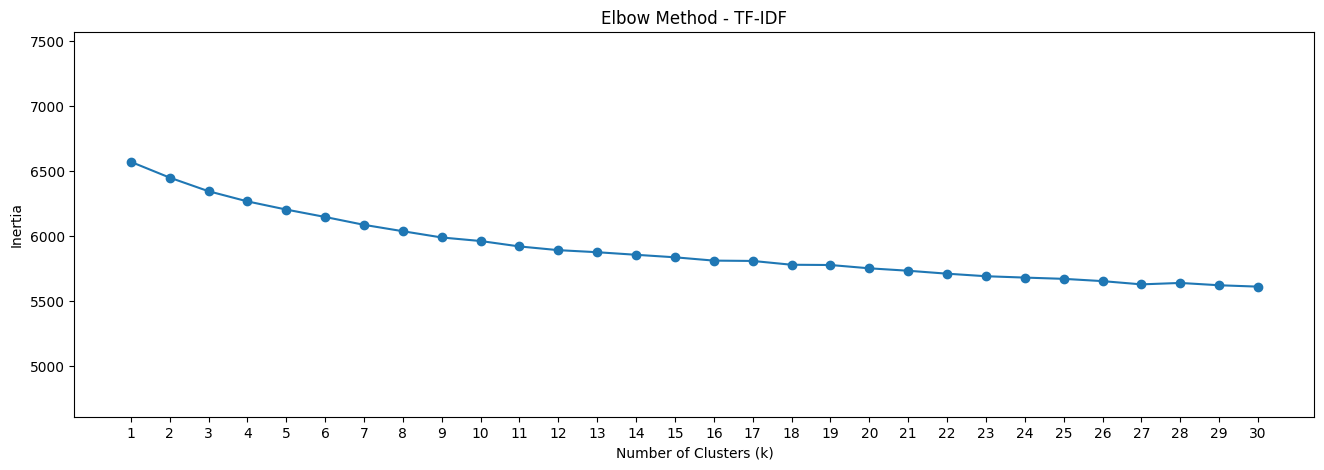

In [10]:
# Para TF-IDF
plot_elbow_method(X_tfidf, max_k = 30, title = "Elbow Method - TF-IDF")

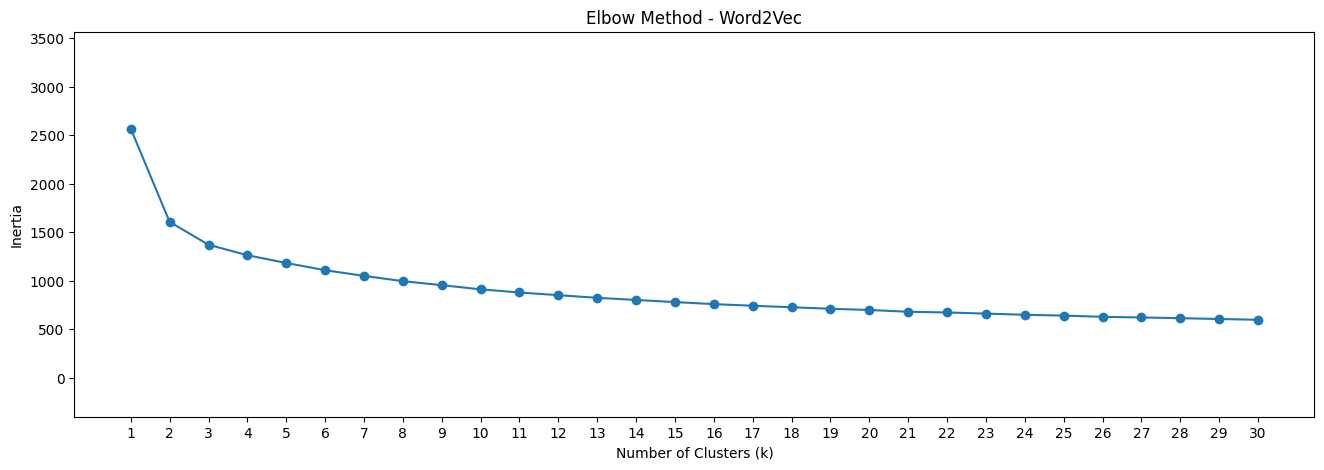

In [11]:
# Para Word2Vec
plot_elbow_method(X_word2vec, max_k = 30, title = "Elbow Method - Word2Vec")

### 4.3 Silhouette score

O Silhouette Score é a média do Silhouette Coefficient de todas as amostras.

O Silhouette Coefficient de uma amostra é calculado da seguinte forma:

$$ s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))} $$

Onde:
- `a(i)` é a distância média entre o ponto `i` e todos os outros pontos do mesmo cluster (cohesão)
- `b(i)` é a distância média entre o ponto `i` e todos os pontos do cluster mais próximo (separação)

Varia entre -1 (pior valor) e 1 (melhor valor).
- Valores próximos a 0 indicam que os clusters se sobrepõem
- Valores negativos indicam que uma amostra foi atribuida a um cluster errado (um cluster diferente é mais similar)

In [11]:
def plot_silhouette_scores(X, max_k = 10, title = "Elbow Method"):
    silhouette_scores = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters = k, random_state = 42)
        kmeans.fit_predict(X)
        # print(silhouette_score(X, kmeans.labels_))
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    
    plt.figure(figsize = (16, 5))
    plt.plot(range(2, max_k + 1), silhouette_scores, marker = 'o')
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.title(title)

    # Configura o range do eixo y
    plt.ylim(min(silhouette_scores) - 0.1, max(silhouette_scores) + 0.1)

    # Configura o eixo x para ir de 1 em 1
    plt.xticks(range(1, max_k + 1, 1))

    plt.show()

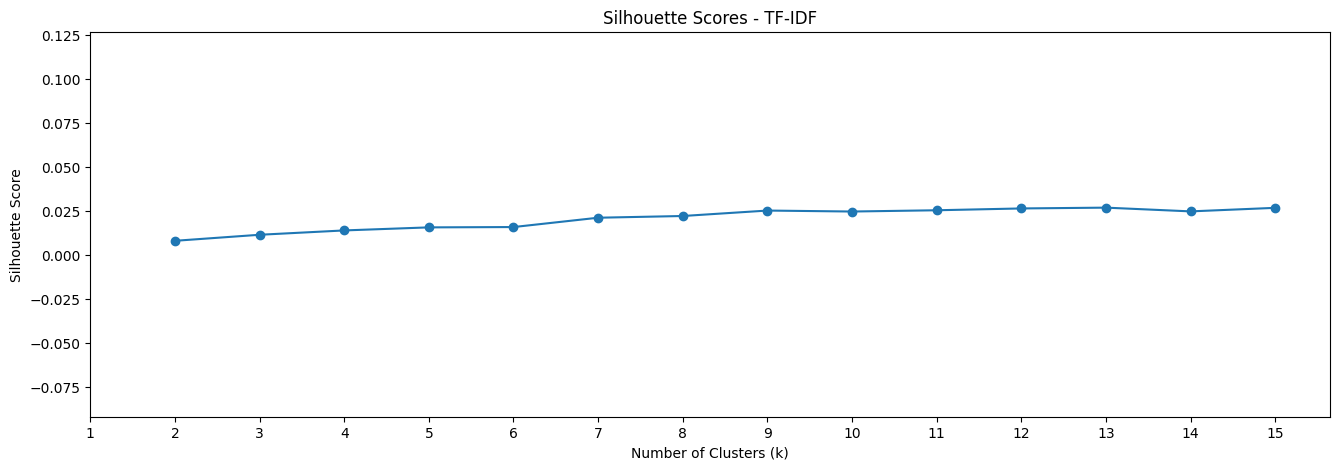

In [12]:
# Para TF-IDF
plot_silhouette_scores(X_tfidf, max_k = 15, title = "Silhouette Scores - TF-IDF")

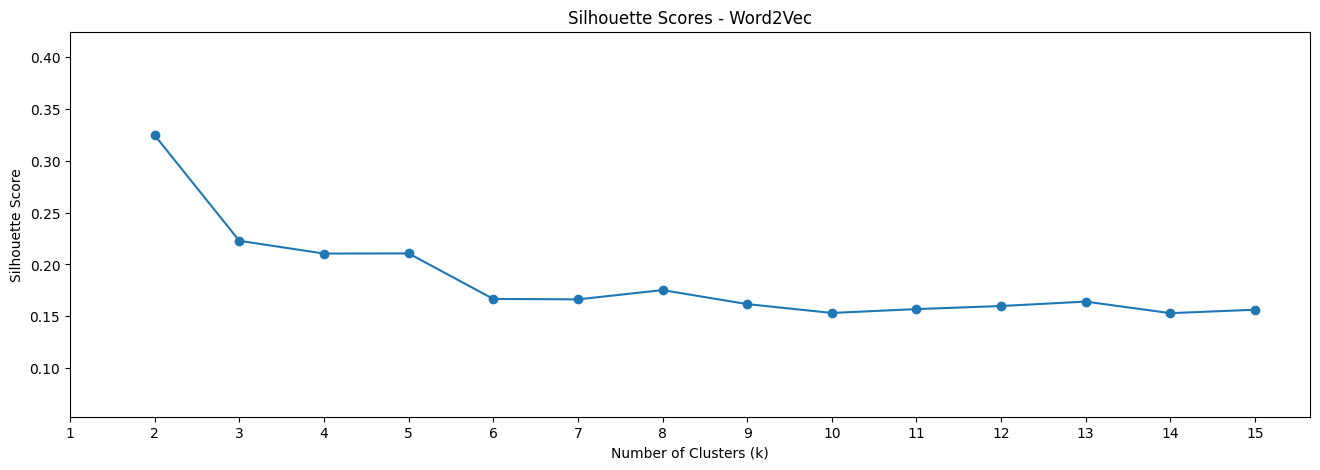

In [103]:
# Para Word2Vec
plot_silhouette_scores(X_word2vec, max_k = 15, title = "Silhouette Scores - Word2Vec")

### 4.2 Aplicar k-means

In [33]:
n_clusters_tfidf = 9
n_clusters_word2vec = 5

In [80]:
kmeans_tfidf = KMeans(n_clusters = n_clusters_tfidf, random_state = 42)
df['cluster_tfidf'] = kmeans_tfidf.fit_predict(X_tfidf)

kmeans_word2vec = KMeans(n_clusters = n_clusters_word2vec, random_state = 42)
df['cluster_word2vec'] = kmeans_word2vec.fit_predict(X_word2vec)

df.head()

,title,price,categoryName,totalScore,reviewsCount,name,comentario,nota,comentario_tratado,tamanho_comentario,preprocessed_text,word2vec_vector,cluster_tfidf,cluster_word2vec
0,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Flavia Bruno,"Comida boa, apesar de ser a peso. A mesa de sa...",3,comida boa apesar de ser a peso a mesa de sala...,257,com boa apes pes mes sal falt rep com sabor em...,"[-0.024902232, 0.111893676, -0.049874827, -0.0...",6,1
1,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Cristiane B Monteiro,Gosto demais da variedade da comida. Não tem c...,5,gosto demais da variedade da comida não tem ch...,163,gost demal variedad com churrasc outr carn boa...,"[0.021548351, 0.063322045, -0.045287907, -0.08...",3,2
2,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Joao Laurindo Duarte,"O restaurante vende refeição por quilo, cheque...",4,o restaurante vende refeição por quilo chequei...,171,restaurant vend refe quil cheq hor fim dev fec...,"[-0.05490535, 0.086802416, 0.015985347, -0.017...",3,1
3,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Mayannah Hingstone,Ótima opção para almoço no setor Jaó. Grande v...,5,ótima opção para almoço no setor jaó grande va...,194,ótim opç almoç set jaó grand variedad com opç ...,"[-0.007226588, 0.027839877, -0.07378422, -0.07...",3,2
4,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Deyvid Linhares,Atendimento excelente!\nComida e preço muito b...,5,atendimento excelentecomida e preço muito bom ...,100,atend excelentecom preç bom fic pes gram torn ...,"[-0.019550826, 0.06726454, -0.01889154, -0.035...",3,1


### 4.3 Palavra mais comum de cada cluster

In [95]:
def nomes_clusters(coluna):

    most_common_words = {}

    for cluster in df[coluna].unique():
        texts_in_cluster = df[df[coluna] == cluster]['preprocessed_text']
        words = " ".join(texts_in_cluster).split()
        word_counts = Counter(words)
        most_common_word = word_counts.most_common(30)#[0]
        most_common_words[cluster] = most_common_word

    tmp = df[coluna].value_counts().reset_index()
    tmp['top_palavras'] = tmp[coluna].map(most_common_words).apply(lambda lista: [t[0] for t in lista])
    
    # palavras exclusivas
    todas_palavras = set(palavra for lista in tmp['top_palavras'] for palavra in lista)

    def palavras_unicas(lista_palavras, todas_palavras, listas_restantes):
        palavras_outras_linhas = set(palavra for lista in listas_restantes for palavra in lista)
        return [palavra for palavra in lista_palavras if palavra not in palavras_outras_linhas]

    tmp['palavras_exclusivas_top'] = tmp.apply(
        lambda row: palavras_unicas(row['top_palavras'], todas_palavras, tmp[tmp.index != row.name]['top_palavras']),
        axis=1
    )

    tmp = tmp[[coluna, 'top_palavras', 'palavras_exclusivas_top', 'count']]

    return tmp

In [96]:
print(f'Silhouette Score TF-IDF: {round(silhouette_score(X_tfidf, kmeans_tfidf.labels_), 5)}')

with pd.option_context('display.max_colwidth', 100):
    display(nomes_clusters(coluna = 'cluster_tfidf')\
            .merge(df.groupby('cluster_tfidf').nota.mean().reset_index()))

Silhouette Score TF-IDF: 0.02517


,cluster_tfidf,top_palavras,palavras_exclusivas_top,count,nota
0,3,"[atend, com, bem, bom, lug, ambi, ped, pra, gost, garçom, local, ótim, bar, preç, agrad, excel, ...","[ped, mes, fic, val, pesso, cheg]",3719,3.940307
1,6,"[boa, com, atend, ambi, bom, lug, músic, agrad, preç, ótim, excel, bem, local, gost, beb, recom,...",[pouc],550,4.660000
2,1,"[melhor, goiân, atend, com, bar, lug, ambi, bom, preç, cervej, excel, reg, ótim, sempr, boa, bem...","[goiân, reg, cidad, pod, restaurant, disc]",512,4.707031
3,4,"[excel, atend, com, ótim, ambi, lug, bom, agrad, bem, local, preç, recom, garçom, boa, sup, deli...","[sabor, not]",468,4.914530
4,2,"[gel, cervej, atend, com, bom, boa, ótim, gost, ambi, bem, lug, excel, sup, músic, preç, sempr, ...","[petisc, tir]",459,4.692810
5,8,"[ótim, atend, com, lug, ambi, bom, agrad, local, sup, delici, preç, gost, recom, cervej, boa, pr...",[serviç],399,4.894737
6,7,"[maravilh, atend, com, lug, ambi, ótim, sup, excel, bom, agrad, recom, garçom, tud, bem, gost, d...","[ame, famíl]",354,4.949153
7,0,"[bom, atend, lug, ambi, com, agrad, preç, gost, tud, local, ótim, recom, músic, gel, delici, bem...","[salg, espaç, car, cardápi]",233,4.768240
8,5,"[top, atend, lug, com, ambi, demal, boa, gel, recom, ótim, sup, bom, agrad, garçom, gost, excel,...","[demal, show, sensac, educ]",171,4.947368


In [97]:
print(f'Silhouette Score Word2Vec: {round(silhouette_score(X_word2vec, kmeans_word2vec.labels_), 5)}')

with pd.option_context('display.max_colwidth', 100):
    display(nomes_clusters(coluna = 'cluster_word2vec')\
            .merge(df.groupby('cluster_word2vec').nota.mean().reset_index()))

Silhouette Score Word2Vec: 0.21061


,cluster_word2vec,top_palavras,palavras_exclusivas_top,count,nota
0,0,"[atend, com, ótim, ambi, bom, lug, excel, boa, agrad, gel, cervej, sup, maravilh, músic, recom, ...","[famili, beb, aconcheg, perfeit, not]",2182,4.853804
1,4,"[atend, com, lug, bom, ambi, excel, ótim, bem, boa, garçom, melhor, sup, gost, local, sempr, pra...","[atenci, amig]",1713,4.706947
2,1,"[atend, com, ped, pra, garçom, mes, fic, bem, bar, bom, lug, local, cheg, melhor, prat, tod, gos...","[ped, mes, fic, cheg, pesso, outr, péss, cas, hor, pag, client, pod]",1612,3.031638
3,2,"[com, atend, bem, bom, preç, boa, cervej, gel, gost, ótim, ambi, excel, serv, prat, carn, opç, p...","[serv, carn, opç, porç, sabor, pouc]",1080,4.490741
4,3,"[melhor, goiân, bar, reg, cervej, atend, com, gel, lug, cidad, ótim, top, excel, disc, frang, bo...","[reg, cidad, disc, frang, rock, torresm, restaurant, cald, dúv, tud, pagod]",278,4.863309


### 4.3 Visualização dos clusters

In [69]:
def pca_plot(metodo):

    print(f"Silhouette Score {metodo}: {round(silhouette_score(eval(f'X_{metodo}'), eval(f'kmeans_{metodo}').labels_), 5)}")

    # Número de clusters
    num_clusters = eval(f'n_clusters_{metodo}')

    # Reduzindo a dimensionalidade para 2D com PCA
    pca = PCA(n_components = 2, random_state = 42)
    
    if type(eval(f'X_{metodo}')) == np.ndarray:
        X_array = eval(f'X_{metodo}')
    else:
        X_array = eval(f'X_{metodo}').toarray()
    
    X_2d = pca.fit_transform(X_array)

    # Aplicando o KMeans e pegando as previsões
    kmeans_pca = eval(f'kmeans_{metodo}')
    clusters = kmeans_pca.fit_predict(eval(f'X_{metodo}'))

    # Plotando o scatter plot
    plt.figure(figsize = (10, 7))
    for cluster in range(num_clusters):
        # Filtrando os pontos de cada cluster
        plt.scatter(X_2d[clusters == cluster, 0], X_2d[clusters == cluster, 1],
                    label=f"Cluster {cluster}", alpha=0.6)

    # Plotando os centróides
    centroids_2d = pca.transform(kmeans_pca.cluster_centers_)
    plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], s = 100, c = 'black', marker = 'X', label = "Centroids")

    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.title(f"Clusters ({metodo.capitalize()})")
    plt.show()


Silhouette Score tfidf: 0.02517


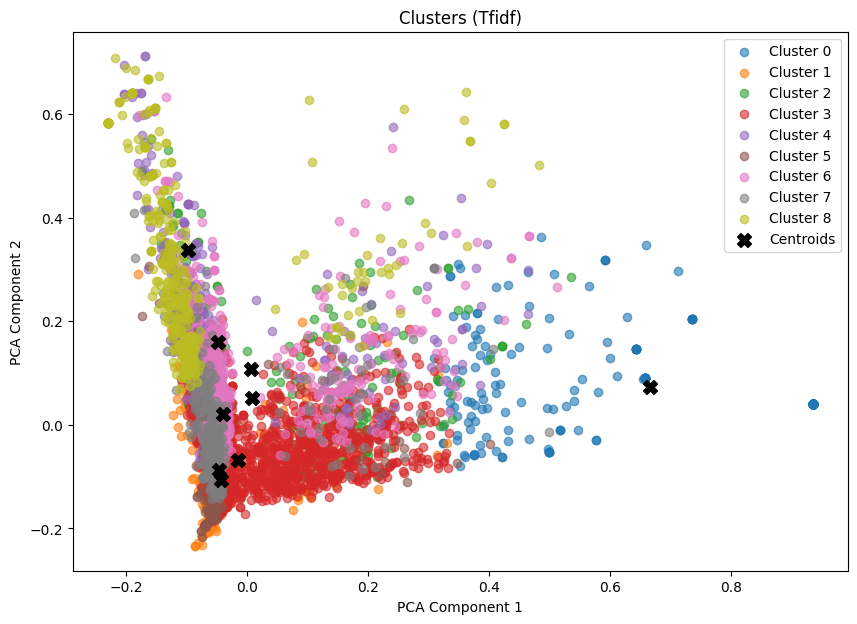

In [70]:
pca_plot(metodo = 'tfidf')

Silhouette Score word2vec: 0.21061


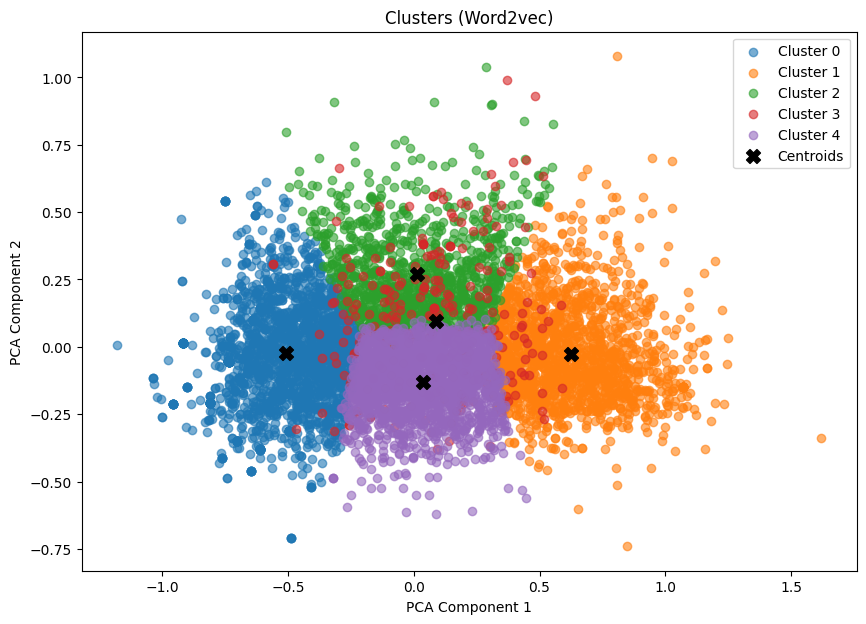

In [102]:
pca_plot(metodo = 'word2vec')

### 4.4 Gráfico do Silhouette Score

In [98]:
# Substitua 'X_tfidf' ou 'X_word2vec' por seu conjunto de dados vetorizado

def silhouette_plot(metodo):
    X = eval(f'X_{metodo}')
    n_clusters = eval(f'n_clusters_{metodo}')

    pca = PCA(n_components=2)

    if type(eval(f'X_{metodo}')) == np.ndarray:
        X_array = eval(f'X_{metodo}')
    else:
        X_array = eval(f'X_{metodo}').toarray()

    X_reduced = pca.fit_transform(X_array)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 8)

    # O primeiro subplot é o gráfico de Silhouette
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])

    # Inicializa o KMeans com n_clusters
    kmeans_silhouette = eval(f'kmeans_{metodo}')
    cluster_labels = kmeans_silhouette.fit_predict(eval(f'X_{metodo}'))

    # Calcula o Silhouette Score médio para todos os pontos
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"Para n_clusters = {n_clusters}, o Silhouette Score médio é: {silhouette_avg}")

    # Calcula os scores de silhouette para cada amostra
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Obtém os valores de silhouette para amostras pertencentes ao cluster i, e ordena
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Rotula os gráficos de silhouette com o número do cluster
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Calcula y_lower para o próximo gráfico
        y_lower = y_upper + 10  # 10 para o espaço entre clusters

    ax1.set_title("Silhouette plot for the various clusters.")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # Linha vertical para o Silhouette Score médio de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.axvline(x=0, color="black", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([# -1, -0.8, -0.6, -0.4, 
                    -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Segundo plot mostrando os clusters formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X_reduced[:, 0], X_reduced[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Marcando os centróides dos clusters
    centers = pca.transform(kmeans_silhouette.cluster_centers_)
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker=f"${i}$", alpha=1, s=50, edgecolor="k")

    ax2.set_title("Visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        f"Silhouette analysis for KMeans clustering on sample data with n_clusters = {n_clusters}",
        fontsize=14,
        fontweight="bold",
    )

plt.show()


Para n_clusters = 9, o Silhouette Score médio é: 0.025169413902180426


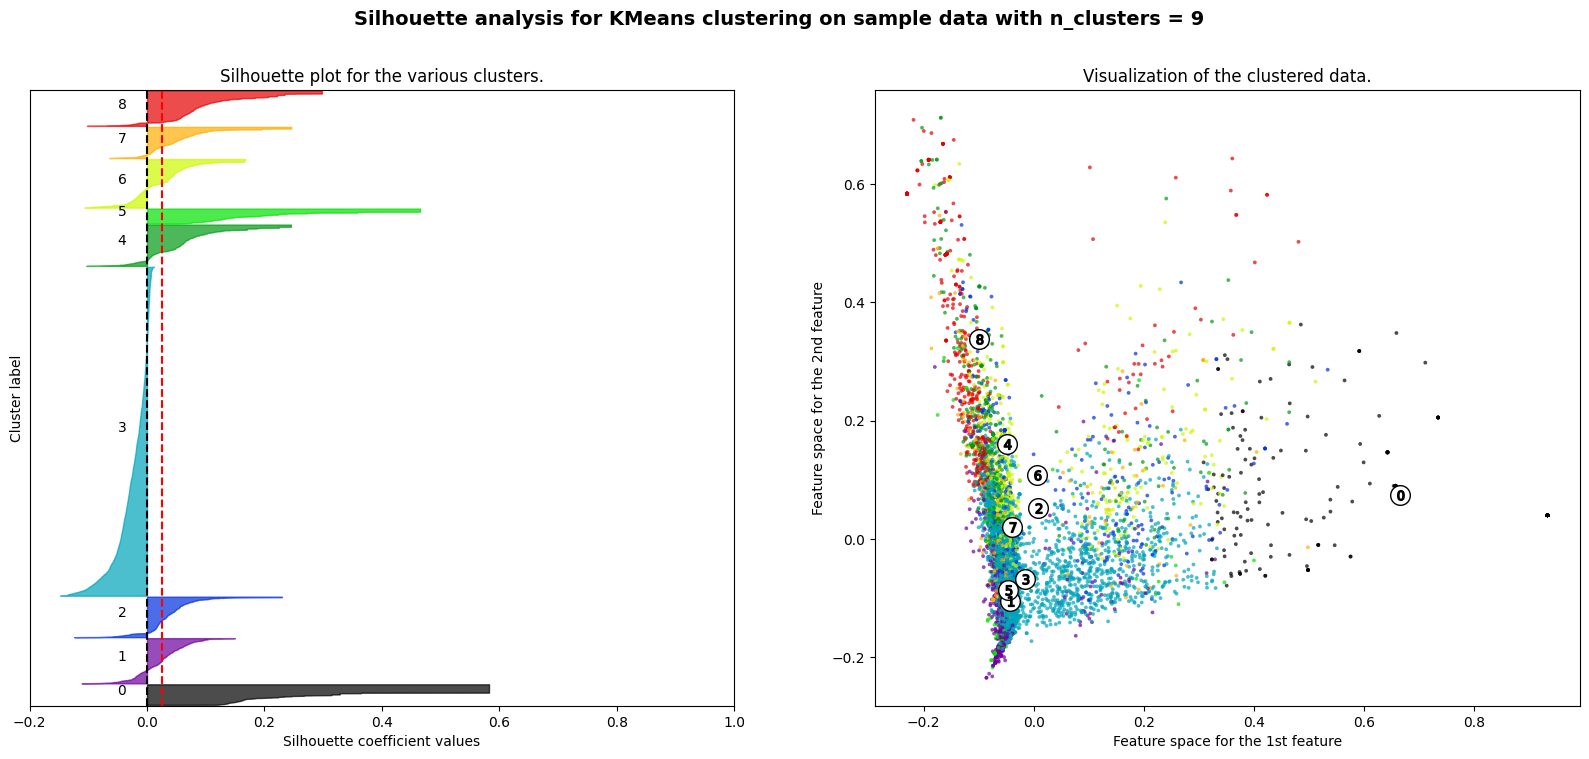

In [99]:
silhouette_plot(metodo = 'tfidf')

Para n_clusters = 5, o Silhouette Score médio é: 0.21061247831923588


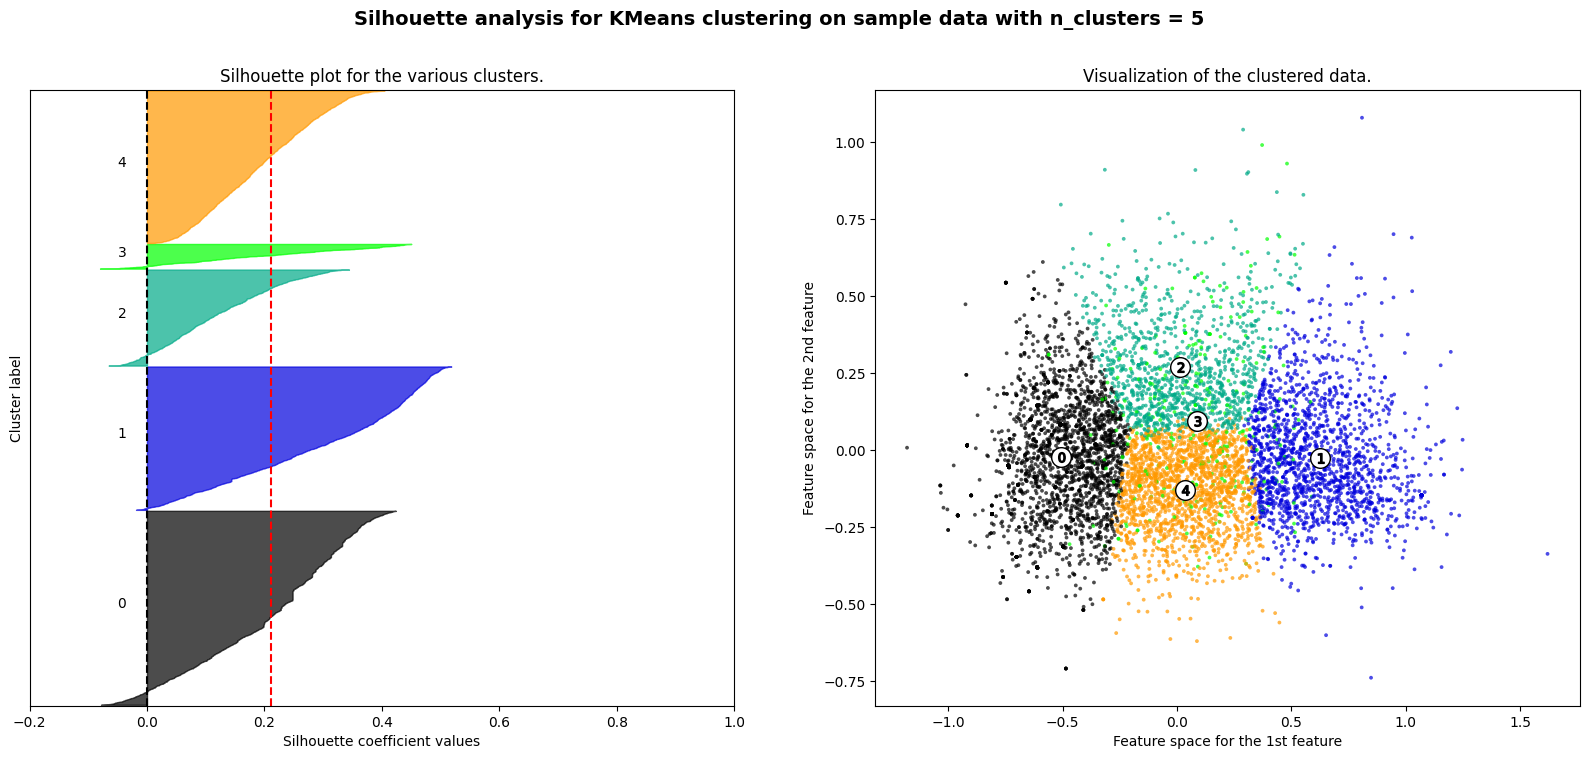

In [101]:
silhouette_plot(metodo = 'word2vec')

## 5. Classificação de uma nova avaliação
Exemplo de nova avaliação:

In [24]:
new_review = "Avaliação de exemplo"
preprocessed_review = preprocess_text(new_review)
review_vector = vectorizer.transform([preprocessed_review])

# Prever o cluster
predicted_cluster = kmeans.predict(review_vector)
predicted_cluster